### Notebook Objective 

Author: Sofia Ingersoll

Date: 2024-07-01


To provide an update on this project to our team, I am subsetting the data that plotted properly in `identifying_ctracts_oversampling.ipynb` and overlaying them to see their overlap relative to the CalEnviroScreen data. An output of 2 csv files containing census tracts that overlapped, and census tracts that did not overlap will be produced, alongside some engaging visualizations. The objective is to create a framework that will be later leveraged once the Climate Vulnerability Metric and EJScreen data are wrangled.


#### Rough Game Plan

##### Quick Mapping
- Read in simple the CA tract data
- Convert everything into geospatial objects
- Assess and identify components provided in each data set (Get familair with data)
- Match CRS + resolution
- Overlay maps to visualize areas without intersectionality 

##### Surveying Application of Results
- Create a xlsx of the census tracts that have zero intersection
- Create a xlsx of the census tracts with the most overlap

##### Interpretting
- What % of CA tracts are within the overlapping regions?
- What is the approximate population within those regions?
- Same questions for those regions **not** intersecting

In [30]:
# loading libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
import xarray as xr 
import rioxarray as rioxr
import rasterio 
import matplotlib.pyplot as plt
import ipyleaflet
import folium
from ipyleaflet import GeoJSON, Map, Marker, Popup, basemap_to_tiles, basemaps, LayersControl, Marker, Popup, GeoData
from ipywidgets import HTML 

from shapely.validation import make_valid


# Function to convert column names to snake_case
def to_snake_case(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('\n', '_').str.lower()
    return df

##### Read n' Wrangle
Okay here we are going to read in the data that were successful in the `identifying_ctracts_oversampling.ipynb` and overlay them.

The data that was being difficult in the other notebook will be excluded for now and added once the cleaning is complete. Climate & Vulnerability Mertics are being a pain bc the files lack complete information regarding geolocation and/or fsip (tract id). EJScreen is also being tempermental.

For consistency's sake CRS EPSG:2227 - NAD83 / California zone 3 (ftUS) was selected because it is best suited for the state of California.

**CalEnviroScreen data** 

Key attributes we'll want to look at easily are `tract`,

In [2]:
# import CES shapefile
calenviro = gpd.read_file('../data/CalEnviroScreen/CES4 Final Shapefile.shp')

# clean naming for easier 
calenviro = to_snake_case(calenviro)

# crs config
calenviro = calenviro.to_crs('EPSG:2227')

calenviro.head(3)

,tract,zip,county,approxloc,totpop19,ciscore,ciscorep,ozone,ozonep,pm2_5,...,elderly65,hispanic,white,africanam,nativeam,othermult,shape_leng,shape_area,aapi,geometry
0,6.083002e+09,93454,Santa Barbara,Santa Maria,4495,36.019653,69.162885,0.034190,10.566273,7.567724,...,12.5028,68.9210,20.8899,0.4004,0.267,1.3126,6999.357689,2.847611e+06,8.2091,"POLYGON ((6580888.757 1071692.998, 6586374.203..."
1,6.083002e+09,93455,Santa Barbara,Santa Maria,13173,37.030667,70.637922,0.035217,11.561917,7.624775,...,5.3519,78.6229,13.2240,2.5051,0.000,0.9489,19100.578232,1.635292e+07,4.6990,"POLYGON ((6580888.757 1071692.998, 6580894.664..."
2,6.083002e+09,93454,Santa Barbara,Santa Maria,2398,31.213140,61.069087,0.034190,10.566273,7.548835,...,12.8857,65.7214,30.6088,0.9591,0.000,2.1685,4970.985897,1.352329e+06,0.5421,"POLYGON ((6586394.940 1074311.362, 6586374.203..."


In [4]:
# how many unique census tracts are accounted for
len(calenviro.tract.unique())

8035

**EJScreen Data**

`id` is the tract_id, however it lacks the necessary geolocation information to make it into a gpd

In [4]:
# read in data & clean colnames 
ejscreen = to_snake_case(pd.read_csv('../data/EJSCREEN_2023_Tracts_StatePct_with_AS_CNMI_GU_VI.csv'))

# isolate CA
ejscreen = ejscreen[ejscreen.state_name == 'California']

# real quick let's convert the geoid10 format to scientific notation to match the other data
# using the g format specifier to automatically choose between fixed and scientific notation based on the number −
# let's also make our lives easier later and convert this column name to tract 
# this will not run if NaN are present, so this confirms the data is clean
ejscreen.loc[:, 'tract'] = ejscreen['id'].apply(lambda x: f'{int(x):.6g}')

ejscreen.head(3)

,oid_,id,state_name,st_abbrev,cnty_name,region,acstotpop,acsipovbas,acseducbas,acstothh,...,p_d5_pwdis,arealand,areawater,npl_cnt,tsdf_cnt,exceed_count_80,exceed_count_80_sup,shape_length,shape_area,tract
4202,4203,6001400100,California,CA,Alameda,9,3324.0,3313.0,2513.0,1337.0,...,25.0,6945856.0,0.0,0,0,0,0.0,0.143536,0.000711,6.0014e+09
4203,4204,6001400200,California,CA,Alameda,9,2038.0,2038.0,1621.0,868.0,...,28.0,586560.0,0.0,0,0,0,0.0,0.041978,0.000060,6.0014e+09
4204,4205,6001400300,California,CA,Alameda,9,5449.0,5410.0,4358.0,2548.0,...,29.0,1110840.0,0.0,0,0,0,0.0,0.055377,0.000114,6.0014e+09


In [6]:
# how many unique census tracts are accounted for
len(ejscreen.tract.unique())

190

In [5]:
# assign geometry to counties using inner join
ejscreen_geo = ejscreen.merge(calenviro, how='inner', left_on = 'cnty_name', right_on='county')

ejscreen_geo.head(3)

,oid_,id,state_name,st_abbrev,cnty_name,region,acstotpop,acsipovbas,acseducbas,acstothh,...,elderly65,hispanic,white,africanam,nativeam,othermult,shape_leng,shape_area_y,aapi,geometry
0,4203,6001400100,California,CA,Alameda,9,3324.0,3313.0,2513.0,1337.0,...,13.6282,39.0835,19.4517,2.9017,0.9606,3.8223,5499.177517,1.273685e+06,33.7803,"POLYGON ((6109597.880 2057572.435, 6108993.110..."
1,4203,6001400100,California,CA,Alameda,9,3324.0,3313.0,2513.0,1337.0,...,14.5768,54.4333,13.9742,3.9311,0.4017,1.4921,4229.811913,8.603767e+05,25.7676,"POLYGON ((6100666.476 2062035.380, 6101005.372..."
2,4203,6001400100,California,CA,Alameda,9,3324.0,3313.0,2513.0,1337.0,...,11.2128,17.0481,15.0114,21.6018,1.3043,1.6476,3576.771195,5.172978e+05,43.3867,"POLYGON ((6060105.422 2117832.474, 6060931.214..."


### The following datum contain their own geographic info

**SB535 Disadvantaged Communities data**

Key attributes we'll want to look at easily are `census_tract`,

In [3]:
# import SB535 Disadvantaged Communities data
sb535_filename = '../data/SB535_disadv_communities/SB535DACresultsdatadictionary_F_2022.xlsx'

sb535 = pd.read_excel(sb535_filename, sheet_name=None)

# collect sb535 sheet names
sb535_sheetnames = list(sb535.keys())

# read in sheets as df
sb535_1 = sb535[sb535_sheetnames[1]]

sb535_2 = sb535[sb535_sheetnames[2]]

sb535_3 = sb535[sb535_sheetnames[3]]

# combine into df
sb535_df = to_snake_case(pd.concat([sb535_1, sb535_2, sb535_3], ignore_index=True))

# create geo object for mapping
sb535_geo = gpd.GeoDataFrame(sb535_df,
                             geometry = gpd.points_from_xy(sb535_df.longitude, sb535_df.latitude),
                             crs = calenviro.crs)

sb535_geo.head(3)

,census_tract,calenviroscreen_4.0_score,calenviroscreen_4.0_percentile,calenviroscreen_4.0__percentile_range,pollution_burden_percentile,population_characteristics_percentile,total_population,california_county,approximate_zip_code,approximate_location,...,poverty,poverty_pctl,unemployment,unemployment_pctl,housing_burden,housing_burden_pctl,pop._char.,pop._char._score,pop._char._pctl,geometry
0,6.001401e+09,40.706036,76.147252,75-80%,66.409459,74.848714,2471.0,Alameda,94608.0,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
1,6.001401e+09,43.736745,80.408472,80-85%,81.829496,70.272315,6133.0,Alameda,94608.0,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
2,6.001401e+09,43.677589,80.345436,80-85%,73.976353,76.059002,3921.0,Alameda,94609.0,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY


In [4]:
# let's also make our lives easier later and convert this column name to tract and remove NaN
sb535_geo.dropna(subset=['census_tract'], inplace=True)
sb535_geo.loc[:, 'tract'] = sb535_geo['census_tract']

# how many unique census tracts are accounted for
len(sb535_geo.tract.unique())

2310

<Axes: >

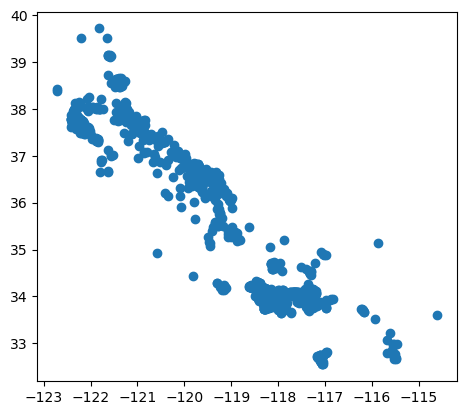

In [5]:
# non-overlapping tracts
sb535_no_overlap = gpd.overlay(sb535_geo, calenviro, how='difference')

sb535_no_overlap.plot()

In [6]:
# Load GeoDataFrame with non-overlapping geometries

# Create a map centered around California
m = Map(center=[36.7783, -119.4179], zoom=5.499)  

# Add GeoDataFrame as GeoJson layer to the map
geo_json = GeoJSON(data=sb535_no_overlap.__geo_interface__)
m.add_layer(geo_json)

# Add Layer control
m.add_control(LayersControl())

# Display the map
m


Map(center=[36.7783, -119.4179], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [ ]:
# annotate the data source
#ax.annotate("Data: U.S. Energy Information Administration (EIA), accessed June 30, 2024 \nhttps://atlas.eia.gov/datasets/eia::power-plants/about", 
 #           xy=(0.25, .06), # position
  #          xycoords='figure fraction', 
   #         fontsize=10, 
    #        color='#555555')

In [8]:
# Create a Map instance
m = Map(center=(37.5, -119.8), zoom=6)

# Add the basemap to the Map instance
m.add_layer(basemap_to_tiles(basemaps.OpenStreetMap.Mapnik))

# Plot your data on the map
sb535_geo_data = GeoData(geo_dataframe=sb535_no_overlap,
                         style={'radius': 4, 'fillColor': 'tab20', 'color': 'black', 'fillOpacity': 0.6, 'weight': 0.9},
                         name='SB535 Non-Overlapping Tracts')

# include non-overlapping SB535 data
m.add_layer(sb535_geo_data)

    # Add markers for each point (tract) with Popup showing additional information
for idx, row in sb535_no_overlap.iterrows():
    marker = Marker(location=(row.geometry.centroid.y, row.geometry.centroid.x))
    popup_content = HTML(value=f"<b>Tract:</b> {row['tract']}<br><b>County:</b> {row['california_county']}")
    marker.popup = Popup(
        location=(row.geometry.centroid.y, row.geometry.centroid.x),
        child=popup_content,
        close_button=False,
        auto_close=False,
        close_on_escape_key=False
    )
    m.add_layer(marker)


# Add Layer control
m.add_control(LayersControl())

# Save the map as an HTML file
m.save('my_map.html')
# Display the map
#m


In [9]:
# Create a Map instance
m = Map(center=(37.5, -119.8), zoom=6)

# Add the basemap to the Map instance
m.add_layer(basemap_to_tiles(basemaps.OpenStreetMap.Mapnik))


# Plot your data on the map (replace sb535_no_overlap with your GeoDataFrame)
sb535_geo_data = GeoData(
    geo_dataframe=sb535_no_overlap,
    style={
        'fillColor': 'county_tract',  # Color code based on 'tract' attribute
        'fillOpacity': 0.6,
        'color': 'county_tract',
        'weight': 0.9
    },
    name='SB535 Non-Overlapping Tracts'
)

m.add_layer(sb535_geo_data)


# Add Layer control
m.add_control(LayersControl())

# Display the map
m

Map(center=[37.5, -119.8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [15]:
# how many unique census tracts are accounted for
len(sb535_no_overlap.tract.unique())

2310

In [17]:
# save non-overlapping regions to a CSV
sb535_no_overlap.to_csv('../no_overlap_tracts/sb535_no_overlap_tracts.csv', index=False)

**SD Climate Equity Index (SD_CEI) data**

Key attributes we'll want to look at easily are `tract`, `cei_score` and `cei_class`

In [7]:
# import sd climate equity index data
sd_cei = gpd.read_file('../data/sd_climate_equity_index/City_of_San_Diego_CEI_2021_Revision.shp')

sd_cei = to_snake_case(sd_cei)

# match crs
sd_cei = sd_cei.to_crs(calenviro.crs)

sd_cei.head(3)

,tract,cei_score_,cei_class_,cei_score1,cei_class1,flood_risk,fire_risk,tree_cover,urban_heat,proximity_,...,bikeabilit,access_to_,traffic_de,electric_v,asthma_rat,cancer_fat,healthy_fo,low_infant,cardiovasc,geometry
0,6.073000e+09,74,High,77,High,0.0,77.64,24.46,3566.57,5.73,...,5.80,0.30,942.39,0.0,33.52,23.26,47.30,1.79,7.23,"POLYGON ((7586946.163 291645.762, 7586947.459 ..."
1,6.073000e+09,73,High,79,High,0.0,59.54,24.81,4141.78,5.18,...,10.70,0.25,1011.62,3.0,33.50,23.21,12.97,1.81,8.58,"POLYGON ((7590659.401 291140.646, 7590674.526 ..."
2,6.073000e+09,78,High,83,Very High,0.0,73.55,19.44,4152.74,4.64,...,14.06,0.29,1576.93,18.0,33.75,23.09,12.40,1.79,6.42,"POLYGON ((7593491.575 291712.769, 7593399.774 ..."


In [8]:
# remove NaN
sd_cei.dropna(subset=['tract'], inplace=True)

# how many unique census tracts are accounted for
len(sd_cei.tract.unique())

297

/var/folders/n4/2w_c819n7nv4fr_mvn5wpsnc0000gn/T/ipykernel_75933/99301996.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 695 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  sd_cei_no_overlap = gpd.overlay(sd_cei, calenviro, how='difference').to_crs(calenviro.crs)


<Axes: >

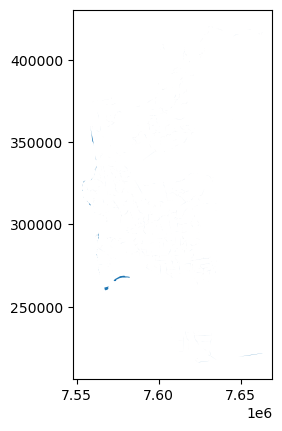

In [15]:
# non-overlapping tracts
sd_cei_no_overlap = gpd.overlay(sd_cei, calenviro, how='difference').to_crs(calenviro.crs)

sd_cei_no_overlap.plot()

In [16]:
# Load GeoDataFrame with non-overlapping geometries

# Create a map centered around California
m = Map(center=[36.7783, -119.4179], zoom=5.499)  

# Add GeoDataFrame as GeoJson layer to the map
geo_json = GeoJSON(data=sd_cei_no_overlap.__geo_interface__)
m.add_layer(geo_json)

# Add Layer control
m.add_control(LayersControl())

# Display the map
m

Map(center=[36.7783, -119.4179], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [ ]:
# save non-overlapping regions to a CSV
sd_cei_no_overlap.to_csv('../no_overlap_tracts/sd_cei_no_overlap_tracts.csv', index=False)

**White House Map data**

Key attributes we'll want to look at is `geoid10`, it may require wrangling to match other tract formats



In [18]:
# import white house map data
wh_map = gpd.read_file('../data/white_house_map/usa/usa.shp',
                       crs = calenviro.crs)

wh_map = to_snake_case(wh_map)

# subset for CA
wh_ca = wh_map[wh_map.sf == 'California'].to_crs(calenviro.crs)

wh_ca.head(3)

,geoid10,sf,cf,df_pfs,af_pfs,hdf_pfs,dsf_pfs,ebf_pfs,ealr_pfs,eblr_pfs,...,age_10,age_middle,age_old,ta_cou_116,ta_count_c,ta_perc,ta_perc_fe,ui_exp,thrhld,geometry
3552,06085507904,California,Santa Clara County,0.20,0.0,0.08,0.36,0.02,NaN,0.01,...,0.09,0.73,0.16,NaN,None,NaN,NaN,Nation,21,"POLYGON ((6126159.951 1938710.503, 6126191.002..."
3553,06085508504,California,Santa Clara County,0.04,0.0,0.02,0.54,0.00,NaN,0.02,...,0.16,0.75,0.07,NaN,None,NaN,NaN,Nation,21,"POLYGON ((6121625.690 1956031.374, 6121625.414..."
3554,06085508505,California,Santa Clara County,0.12,0.0,0.07,0.67,0.00,NaN,0.01,...,0.13,0.68,0.18,NaN,None,NaN,NaN,Nation,21,"POLYGON ((6121624.707 1955970.577, 6121625.414..."


In [12]:
# real quick let's convert the geoid10 format to scientific notation to match the other data
# using the g format specifier to automatically choose between fixed and scientific notation based on the number −
# let's also make our lives easier later and convert this column name to tract 
# this will not run if NaN are present, so this confirms the data is clean
wh_ca.loc[:, 'tract'] = wh_ca['geoid10'].apply(lambda x: f'{int(x):.6g}')

# how many unique census tracts are accounted for
len(wh_ca.tract.unique())

/Users/sofiaingersoll/anaconda3/envs/eds-env/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


188

In [ ]:
wh_ca.tract

3552     6.08551e+09
3553     6.08551e+09
3554     6.08551e+09
3555     6.08551e+09
3556     6.08551e+09
            ...     
11604     6.0371e+09
11605     6.0371e+09
11606     6.0371e+09
11607     6.0371e+09
73976    6.03793e+09
Name: tract, Length: 8057, dtype: object

/var/folders/n4/2w_c819n7nv4fr_mvn5wpsnc0000gn/T/ipykernel_75933/4050883151.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 29149 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  wh_no_overlap = gpd.overlay(wh_ca, calenviro, how='difference')


<Axes: >

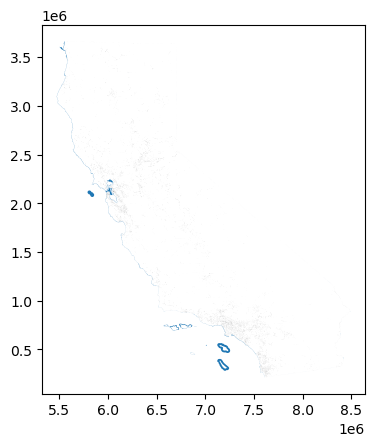

In [19]:
# non-overlapping tracts
wh_no_overlap = gpd.overlay(wh_ca, calenviro, how='difference')

wh_no_overlap.plot()

In [14]:
# Load GeoDataFrame with non-overlapping geometries

# Create a map centered around California
m = Map(center=[36.7783, -119.4179], zoom=5.499)  

# Add GeoDataFrame as GeoJson layer to the map
geo_json = GeoJSON(data=wh_no_overlap.__geo_interface__)
m.add_layer(geo_json)

# Add Layer control
m.add_control(LayersControl())

# Display the map
m

Map(center=[36.7783, -119.4179], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

**DOE's Energy Justice Mapping Tool - Disadvantaged Communities Reporter (EJMT) data**

Key attributes we'll want to look at is `geoid`, it may require wrangling to match other tract formats

In [36]:
# import doe energy justice mapping tool data
doe_ejmt = gpd.read_file('../data/DOE_EJ_mapping_tool/DAC Shapefiles (v2022c).shp',
                         crs = calenviro.crs)

doe_ejmt = to_snake_case(doe_ejmt)

doe_ejmt_ca = doe_ejmt[doe_ejmt.stateabb == 'CA']

doe_ejmt_ca.head(3)

,geoid,city,county,stateabb,countyfips,cbsa,cbsaname,statefips,population,dacsts,...,disablpct,incplmbpct,snglpntpct,mobilhmpct,nongridpct,lesshspct,lowincfpct,lowincapct,eal_npctl,geometry
263,06003010000,Markleeville,"Alpine County, CA",CA,6003,99999,None,6,1039.0,0,...,0.159769,0.000000,0.386503,0.017946,0.848571,0.088312,0.388835,0.232877,98.801193,"POLYGON ((-13366398.426 4679189.192, -13365864..."
264,06007001300,Chico,"Butte County, CA",CA,6007,17020,"Chico, CA",6,3689.0,0,...,0.173486,0.000000,0.485294,0.034864,0.032665,0.200159,0.514184,0.539340,91.930051,"POLYGON ((-13562009.036 4826320.661, -13561775..."
266,06015000203,Klamath,"Del Norte County, CA",CA,6015,18860,"Crescent City, CA",6,1251.0,0,...,0.301920,0.008811,0.634615,0.432810,0.607930,0.181319,0.539267,0.416000,75.575688,"POLYGON ((-13820782.324 5120426.256, -13819546..."


In [37]:
# real quick let's convert the geoid10 format to scientific notation to match the other data
# using the g format specifier to automatically choose between fixed and scientific notation based on the number −
# let's also make our lives easier later and convert this column name to tract 
# this will not run if NaN are present, so this confirms the data is clean
doe_ejmt_ca.loc[:, 'tract'] = doe_ejmt_ca['geoid'].apply(lambda x: f'{int(x):.6g}')

# how many unique census tracts are accounted for
len(doe_ejmt_ca.tract.unique())

/Users/sofiaingersoll/anaconda3/envs/eds-env/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


188

In [ ]:
doe_ejmt_ca.tract

263      6.00301e+09
264        6.007e+09
266        6.015e+09
267      6.02301e+09
268      6.02394e+09
            ...     
71260    6.07101e+09
71262    6.07101e+09
71264    6.07101e+09
72940    6.05999e+09
73031    6.06199e+09
Name: tract, Length: 8057, dtype: object

In [39]:
# non-overlapping tracts
doe_ejmt_ca = doe_ejmt_ca.to_crs(calenviro.crs)

# Apply the function to fix geometries in doe_ejmt_ca
doe_ejmt_valid = doe_ejmt_ca.is_valid()

doe_ejmt_no_overlap = gpd.overlay(doe_ejmt_valid, calenviro, how='difference')

doe_ejmt_no_overlap.plot()


TypeError: 'Series' object is not callable

In [23]:
# Load GeoDataFrame with non-overlapping geometries

# Create a map centered around California
m = Map(center=[36.7783, -119.4179], zoom=5.499)  

# Add GeoDataFrame as GeoJson layer to the map
geo_json = GeoJSON(data=wh_no_overlap.__geo_interface__)
m.add_layer(geo_json)

# Add Layer control
m.add_control(LayersControl())

# Display the map
m

Map(center=[36.7783, -119.4179], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

**CDC CA Social Vulnearability Index (SVI)**

In [ ]:
cdc_svi = to_snake_case(pd.read_csv('../data/CDC_Index/California_SVI.csv'))

cdc_svi

# real quick let's convert the geoid10 format to scientific notation to match the other data
# using the g format specifier to automatically choose between fixed and scientific notation based on the number −
# let's also make our lives easier later and convert this column name to tract 
# this will not run if NaN are present, so this confirms the data is clean
cdc_svi.loc[:, 'tract'] = cdc_svi['fips'].apply(lambda x: f'{int(x):.6g}')

cdc_svi.head(3)

,st,state,st_abbr,stcnty,county,fips,location,area_sqmi,e_totpop,m_totpop,...,mp_asian,ep_aian,mp_aian,ep_nhpi,mp_nhpi,ep_twomore,mp_twomore,ep_otherrace,mp_otherrace,tract
0,6,California,CA,6001,Alameda County,6001400100,Census Tract 4001; Alameda County; California,2.681809,3269,452,...,3.7,0.0,1.2,0.0,1.2,5.3,2.7,0.8,0.9,6.0014e+09
1,6,California,CA,6001,Alameda County,6001400200,Census Tract 4002; Alameda County; California,0.226472,2147,201,...,4.5,0.4,0.7,0.0,1.8,8.5,3.4,0.4,0.5,6.0014e+09
2,6,California,CA,6001,Alameda County,6001400300,Census Tract 4003; Alameda County; California,0.428898,5619,571,...,3.3,0.5,0.5,0.0,0.7,9.1,4.8,1.1,1.0,6.0014e+09


In [ ]:
# how many unique census tracts are accounted for
len(cdc_svi.tract.unique())

173

### Overlaying

I want to reduce the size of the data as much as possible before performing inner-join and outer-joins on the the data. So, we're going to only select the most pertenent information from each dataset to join with using SQL

Firstly, let's isolate unique census tracts in the data sets and combine only the unique `tract`

##### Ideas

Using the `tract` column, combine the df for plotting

Instead of concatination, let's do an inner join? so keeping observations that are present in both and removing those outside

To combine the Climate Vulnerability Metrics (CVM) I need an intermediate table of the county_fips and associated census_tracts, this is what we will use to relate our combined data at the CVM data.

**Since the directions as for overlap**

*Notes: CRS + resolution need to match across the board*


In [ ]:
# Create a Map instance
m = Map(center=(37.5, -119.8), zoom=6)

# Add the basemap to the Map instance
m.add_layer(basemap_to_tiles(basemaps.OpenStreetMap.Mapnik))

# Plot your data on the map (replace sd_cei_no_overlap with your GeoDataFrame)
sd_cei_geo_data = GeoData(
    geo_dataframe=sd_cei_no_overlap,
    style={
        'fillColor': 'county_tract',  # Color code based on 'tract' attribute
        'fillOpacity': 0.6,
        'color': 'county_tract',
        'weight': 0.9
    },
    name='sd_cei Non-Overlapping Tracts'
)

m.add_layer(sd_cei_geo_data)

# Add Layer control
m.add_control(LayersControl())

# Display the map
m

Map(center=[37.5, -119.8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [ ]:
# Create a Map instance
m = Map(center=(37.5, -119.8), zoom=6)

# Add the basemap to the Map instance
m.add_layer(basemap_to_tiles())

# Plot your data on the map (replace with your GeoDataFrames)
sb535_geo_data = GeoData(
    geo_dataframe=sb535_no_overlap,
    style={
        'fillColor': 'tab20',  # Color code based on 'tract' attribute
        'fillOpacity': 0.6,
        'color': 'black',
        'weight': 0.9
    },
    name='SB535 Non-Overlapping Tracts'
)

m.add_layer(sb535_geo_data)

# Plot non-overlapping tracts from sd_cei_no_overlap as another layer
sd_cei_geo_data = GeoData(
    geo_dataframe=sd_cei_no_overlap,
    style={
        'fillColor': 'red',  # Example color for non-overlapping tracts
        'fillOpacity': 0.6,
        'color': 'black',
        'weight': 0.9
    },
    name='SD CEI Non-Overlapping Tracts'
)

m.add_layer(sd_cei_geo_data)

# Display the map
m

In [ ]:
-- SQL to combine data

